In [144]:
from azureml.core import Workspace
ws = Workspace.from_config()

print('connected to:', ws.name)

connected to: machinelearning


In [145]:
from azureml.core.model import Model
import os

# model =  Model.register(workspace= ws, 
#                         model_path= 'trees-v1.h5', 
#                         model_name= 'Vegetation',
#                         tags= {'tensorflow': 'wildfire spatial prediction demo'}, 
#                         description= 'Image Segmentation on vegetation terrain')

model = Model(ws, name= 'Vegetation', version= 1)
print(model.name, 'model loaded')

Vegetation model loaded


In [146]:
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

env = Environment('ModelTrees')


for pip_package in ['inference-schema[numpy-support]', 'tensorflow', 'joblib', 'keras', 'pillow==5.4.1', 'azureml-contrib-services', 'azureml-defaults']:
    env.python.conda_dependencies.add_pip_package(pip_package)

inference_config = InferenceConfig(entry_script= 'score.py', environment= env)
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)


print(env, inference_config)

Environment(Name: ModelTrees,
Version: None) InferenceConfig(entry_script=score.py, runtime=None, conda_file=None, extra_docker_file_steps=None, source_directory=None, enable_gpu=None, base_image=None, base_image_registry=<azureml.core.container_registry.ContainerRegistry object at 0x7f94615d1668>)


In [149]:
from azureml.core.webservice import LocalWebservice, Webservice

deployment_config = LocalWebservice.deploy_configuration(port=8000)
service = Model.deploy(ws, "myservice1", [model], inference_config, aci_config)
service.wait_for_deployment(show_output = True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-04-04 19:19:44+00:00 Creating Container Registry if not exists.
2021-04-04 19:19:44+00:00 Registering the environment.
2021-04-04 19:19:48+00:00 Use the existing image.
2021-04-04 19:19:48+00:00 Generating deployment configuration..
2021-04-04 19:19:52+00:00 Submitting deployment to compute.
2021-04-04 19:19:57+00:00 Checking the status of deployment myservice1..
2021-04-04 19:23:00+00:00 Checking the status of inference endpoint myservice1.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [152]:
service

AciWebservice(workspace=Workspace.create(name='machinelearning', subscription_id='60b11d04-49e1-47c9-8768-f169e5b4d0fb', resource_group='resources'), name=myservice1, image_id=None, compute_type=None, state=ACI, scoring_uri=Healthy, tags=http://67515655-f00a-44a0-a447-22a76351d991.eastus.azurecontainer.io/score, properties={}, created_by={'hasInferenceSchema': 'False', 'hasHttps': 'False'})

In [66]:
import json

sample_input = json.dumps({
    'data': 'asfd'
})

service.run(sample_input)

Checking container health...
Local webservice is running at http://localhost:8890


'azureml-models/Vegetation/1/trees-v1.h5'

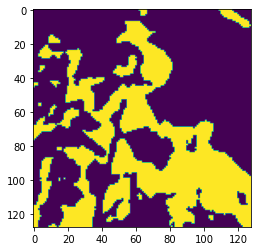

In [169]:
import requests 
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

image_name = '26.png'

img = Image.open(image_name)
orig_size = img.size

files = {'image': open(image_name, 'rb').read()}
response = requests.post('http://67515655-f00a-44a0-a447-22a76351d991.eastus.azurecontainer.io/score', files= files)

new_img = response.json()
new_img = np.array(new_img, dtype='uint8')
plt.imshow(new_img)

In [136]:
service.reload()

Container has been successfully cleaned up.
Starting Docker container...
Docker container running.


In [59]:
service.update(
    models= [model],
    inference_config= inference_config,
    deployment_config= deployment_config
)

Generating Docker build context.
2021/04/04 02:03:25 Downloading source code...
2021/04/04 02:03:27 Finished downloading source code
2021/04/04 02:03:27 Creating Docker network: acb_default_network, driver: 'bridge'
2021/04/04 02:03:27 Successfully set up Docker network: acb_default_network
2021/04/04 02:03:27 Setting up Docker configuration...
2021/04/04 02:03:28 Successfully set up Docker configuration
2021/04/04 02:03:28 Logging in to registry: e1beb0b7f8eb4722a424ef506535ae8b.azurecr.io
2021/04/04 02:03:29 Successfully logged into e1beb0b7f8eb4722a424ef506535ae8b.azurecr.io
2021/04/04 02:03:29 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/04/04 02:03:29 Scanning for dependencies...
2021/04/04 02:03:30 Successfully scanned dependencies
2021/04/04 02:03:30 Launching container with name: acb_step_0
Sending build context to Docker daemon  66.56kB
Step 1/18 : FROM mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:2021022